In [1]:
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import mean_squared_error
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import random

import warnings

warnings.filterwarnings("ignore")

In [2]:
data = np.load('GC_Dataset_ped1-12685_time1000-1060_interp9_xrange5-25_yrange15-35.npy', allow_pickle=True)

In [97]:
class PedestrianLSTM(nn.Module):
    def __init__(self, input_size=2, hidden_layer_size=100, output_size=2):
        super(PedestrianLSTM, self).__init__()
        self.hidden_layer_size = hidden_layer_size
        self.lstm = nn.LSTM(input_size, hidden_layer_size)
        self.linear = nn.Linear(hidden_layer_size, output_size)

    def forward(self, input_seq):
        lstm_out, _ = self.lstm(input_seq.view(len(input_seq), 1, -1))
        predictions = self.linear(lstm_out.view(len(input_seq), -1))
        return predictions[-1]

def prepare_data(pedestrian_data, seq_length=1):
    X = []
    y = []
    for i in range(len(pedestrian_data) - seq_length):
        seq = pedestrian_data[i:i+seq_length]
        label = pedestrian_data[i+seq_length]
        print(seq, label)
        X.append(seq)
        y.append(label)
    return torch.tensor(X, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)

def train_model(train_data, epochs=1000):
    model = PedestrianLSTM()
    loss_function = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    for epoch in range(epochs):
        for seq, labels in train_data:
            optimizer.zero_grad()
            y_pred = model(seq)
            single_loss = loss_function(y_pred, labels)
            single_loss.backward()
            optimizer.step()
    return model

def split_data(data, train_ratio=0.6):
    train_data, test_data = [], []
    for pedestrian in data:
        split_idx = int(len(pedestrian) * train_ratio)
        train_data.append(pedestrian[:split_idx])
        test_data.append(pedestrian[split_idx:])
    return train_data, test_data

def evaluate_model_on_data(model, data):
    model.eval()
    mse_scores = []
    with torch.no_grad():
        for pedestrian in data:
            if len(pedestrian) > 0:
                X, y = prepare_data(np.array(pedestrian)[:, :2])
                predictions = [model(seq).numpy() for seq in X]
                mse = mean_squared_error(y, predictions)
                mse_scores.append(mse)
    return np.mean(mse_scores), predictions

In [ ]:
subset_len = len(data[1])
# Split the data into training and test sets
train_data, test_data = split_data(data[1][:subset_len])

# Train and evaluate the model for each pedestrian
train_pred_gps = {}
for i in range(750):
    train_pred_gps[i] = [None] * len(data[1][:subset_len])

test_pred_gps = {}
for i in range(750):
    test_pred_gps[i] = [None] * len(data[1][:subset_len])

for i, pedestrian in tqdm(enumerate(train_data)):
    # print(f"Pedestrian {i}")
    if len(pedestrian) > 1:  # Ensure there's enough data
        X_train, y_train = prepare_data(np.array(pedestrian)[:, :2])
        train_dataset = TensorDataset(X_train, y_train)
        train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)

        model = train_model(train_loader, epochs=20)  # Adjust epochs as needed

        model.eval()


        # with torch.no_grad():
        #     X_train, y_train = prepare_data(np.array(train_data[i])[:, :2])
        #     train_frames = np.array(train_data[i])[:, -1]
        #     train_pred = [model(seq).numpy() for seq in X_train]
        #     print(train_pred)
        #     print(train_frames)

        with torch.no_grad():
            X_test, y_test = prepare_data(np.array(test_data[i])[:, :2])
            test_frames = np.array(test_data[i])[:, -1]
            test_pred = [model(seq).numpy() for seq in X_test]

        with torch.no_grad():
            X_train, y_train = prepare_data(np.array(train_data[i])[:, :2])
            train_frames = np.array(train_data[i])[:, -1]
            train_pred = [model(seq).numpy() for seq in X_train]


        # print(test_pred)
        # print(test_frames[1:])
        for j, frame in enumerate(test_frames[1:]):
            # print(i, frame)
            test_pred_gps[int(frame)][i] = tuple(test_pred[j])

        for j, frame in enumerate(train_frames[1:]):
            # print(i, frame)
            train_pred_gps[int(frame)][i] = tuple(train_pred[j])

        # print(train_data[i], test_data[i])


        # train_mses = []
        # with torch.no_grad():
        #     for pedestrian in [train_data[i]]:
        #         if len(pedestrian) > 0:
        #             X_train, y_train = prepare_data(np.array(pedestrian)[:, :2])
        #             train_pred = [model(seq).numpy() for seq in X_train]
        #             train_mse = mean_squared_error(y_train, train_pred)
        #             train_mses.append(train_mse)



        # test_mse, test_pred = evaluate_model_on_data(model, [test_data[i]])  # Test data is a list containing test set for one pedestrian
        # train_mse, train_pred = evaluate_model_on_data(model, [train_data[i]])  # Train data is a list containing test set for one pedestrian
        # print(f"The test MSE: {test_mses}")
        # print(f"The train MSE: {train_mses}")
        # print(len(train_data[i]))
        # print(len(test_data[i]))
        # print(len(train_pred))
        # print(len(test_pred))
        # all_train_mses.append(np.mean(train_mses))
        # all_test_mses.append(np.mean(test_mses))

In [48]:
palette = sns.color_palette("Spectral", 122)
np.random.seed(42)
random.shuffle(palette)

In [107]:
def plot_all_pedestrians(gps, title, num_traj, linestyle='-.'):
    plt.figure()

    for i in range(num_traj):
        predicted_positions = []
        for j in range(len(gps)):
            if gps[j][i] is not None:
                predicted_positions.append(gps[j][i])

        x_vals = []
        y_vals = []
        for (x, y) in predicted_positions:
            if x < 5 or y < 15 or x > 25 or y > 35:
                break
            else:
                x_vals.append(x-5)
                y_vals.append(y-15)

        # x_vals = np.array([x[0]-5 for x in predicted_positions])
        # y_vals = np.array([x[1]-15 for x in predicted_positions])

        if len(x_vals) > 0:
            color = tuple(palette[i])  # Get the color for the current pedestrian
            # print(x_vals)
            # print(y_vals)
            # # Plot true and predicted paths
            # # plt.plot(true_positions[:, 0], true_positions[:, 1], label=f'True Path {i}', color=color, alpha=0.7)
            plt.plot(x_vals, y_vals, color=color,  label=f'Predicted Path {i}')
            # # Mark the start (triangle) and end (square) of true and predicted paths
            # # plt.plot(true_positions[0, 0], true_positions[0, 1], marker='^', markersize=4, color=color, alpha=0.7)  # Triangle for start
            # # plt.plot(true_positions[-1, 0], true_positions[-1, 1], marker='s', markersize=4, color=color, alpha=0.7)  # Square for end
            plt.plot(x_vals[0], y_vals[0], marker='^', color=color, markersize=4)  # Triangle for start
            plt.plot(x_vals[-1], y_vals[-1], marker='s', color=color, markersize=4)  # Square for end
        

    # plt.legend()
    # plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
    plt.title(title)
    plt.ylim(0,20)
    plt.xlim(0,20)
    plt.show()

    return plt

In [108]:
true_gps = {}
for i in range(750):
    true_gps[i] = [None] * len(data[1][:subset_len])

for person_id, person_data in enumerate(data[1][:subset_len]):
    for position in person_data:
        x, y, frame = position
        true_gps[frame][person_id] = (x, y)

In [109]:
filtered_train_true_gps = {}
for i in range(750):
    filtered_train_true_gps[i] = [None] * len(data[1][:subset_len])

for frame in train_pred_gps:
    for person_id in range(len(train_pred_gps[frame])):
        if train_pred_gps[frame][person_id] is not None:
            filtered_train_true_gps[frame][person_id] = true_gps[frame][person_id]

In [110]:
filtered_test_true_gps = {}
for i in range(750):
    filtered_test_true_gps[i] = [None] * len(data[1][:subset_len])

for frame in test_pred_gps:
    for person_id in range(len(test_pred_gps[frame])):
        if test_pred_gps[frame][person_id] is not None:
            filtered_test_true_gps[frame][person_id] = true_gps[frame][person_id]

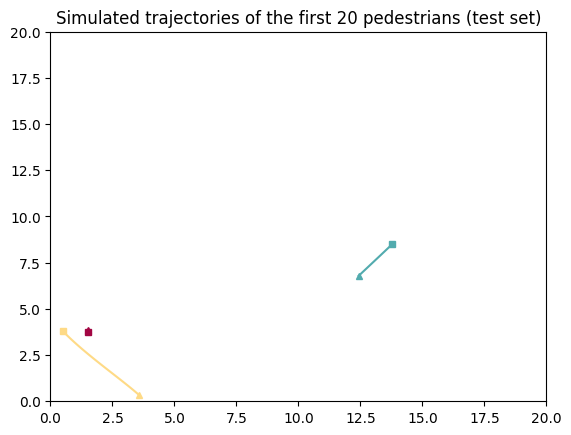

<module 'matplotlib.pyplot' from '/Users/ben1/miniconda3/lib/python3.11/site-packages/matplotlib/pyplot.py'>

In [111]:
# plot_all_pedestrians(train_pred_gps, 'Predicted Paths for All Pedestrians (Train)', linestyle='-.')
plot_all_pedestrians(test_pred_gps, 'Simulated trajectories of the first 20 pedestrians (test set)', 20, linestyle='-.')

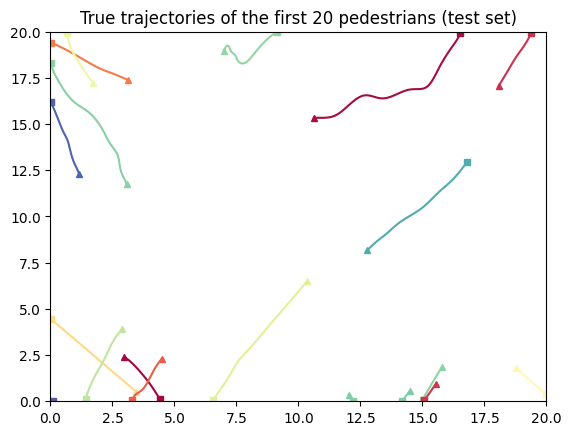

<module 'matplotlib.pyplot' from '/Users/ben1/miniconda3/lib/python3.11/site-packages/matplotlib/pyplot.py'>

In [75]:
# plot_all_pedestrians(filtered_train_true_gps, 'Actual Paths for All Pedestrians (Train)', linestyle='-')
plot_all_pedestrians(filtered_test_true_gps, 'True trajectories of the first 20 pedestrians (test set)', 20, linestyle='-')

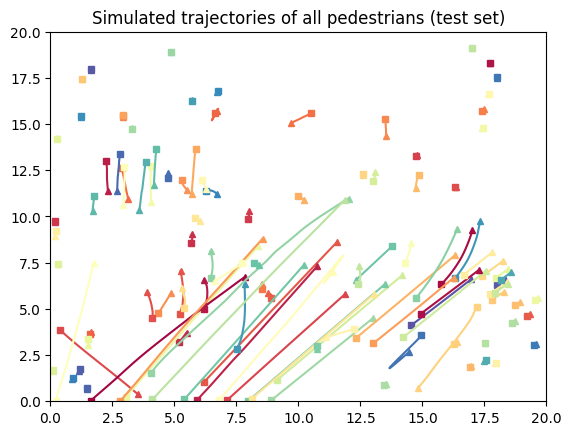

<module 'matplotlib.pyplot' from '/Users/ben1/miniconda3/lib/python3.11/site-packages/matplotlib/pyplot.py'>

In [17]:
plot_all_pedestrians(test_pred_gps, 'Simulated trajectories of all pedestrians (test set)', len(test_pred_gps[0]), linestyle='-.')

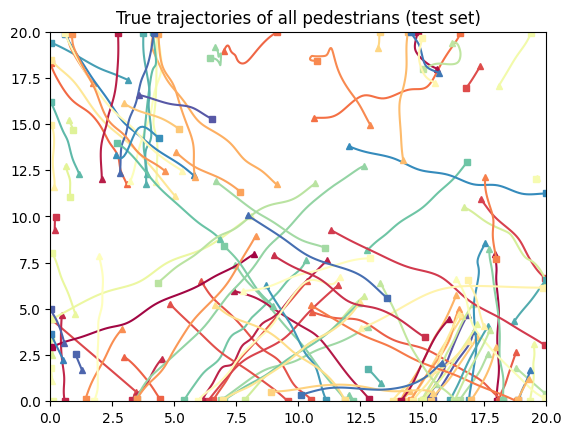

<module 'matplotlib.pyplot' from '/Users/ben1/miniconda3/lib/python3.11/site-packages/matplotlib/pyplot.py'>

In [18]:
plot_all_pedestrians(filtered_test_true_gps, 'True trajectories of all pedestrians (test set)', len(filtered_test_true_gps[0]), linestyle='-')

In [30]:
true_gps[154][1]
# 154th frame, person 1

(8.172081313382622, 15.839631407538226)

In [31]:
test_pred_gps[154][1]
# 154th frame, person 1

(8.287086, 15.662272)

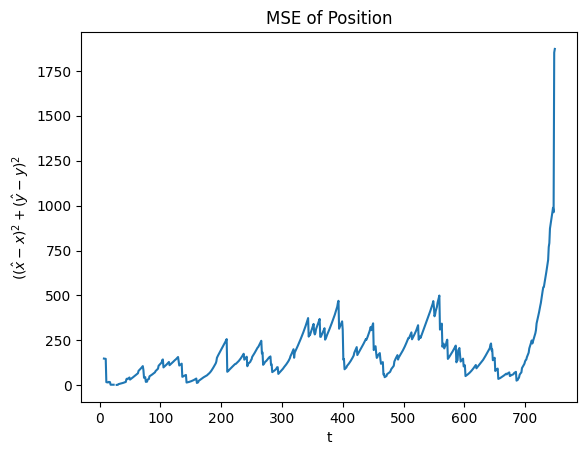

In [37]:
import matplotlib.pyplot as plt

def calculate_mse_for_frame(true_positions, pred_positions):
    filtered_pairs = [(true, pred) for true, pred in zip(true_positions, pred_positions) if true is not None and pred is not None]

    if not filtered_pairs:
        return np.nan

    filtered_true, filtered_pred = zip(*filtered_pairs)

    true_arr = np.array(filtered_true)
    pred_arr = np.array(filtered_pred)

    squared_diffs = (true_arr - pred_arr) ** 2

    mse = np.sum(squared_diffs)
    return mse

frame_test_gps_mse = [calculate_mse_for_frame(filtered_test_true_gps[frame], test_pred_gps[frame]) for frame in range(750)]

plt.plot(range(750), frame_test_gps_mse)
plt.xlabel("t")
plt.ylabel(r"$((\hat{x}-x)^2 + (\hat{y}-y)^2$")
plt.title("MSE of Position")
plt.show()

frame_train_gps_mse = [calculate_mse_for_frame(filtered_train_true_gps[frame], train_pred_gps[frame]) for frame in range(750)]

# plt.plot(range(750), frame_train_gps_mse)
# plt.xlabel("t")
# plt.ylabel("MSE of Position")
# # plt.ylim(0, 80)
# plt.title("MSE of Position (Train)")
# plt.show()


In [12]:
print(f"Mean MSE of Positions Across Frames (Train): {np.nanmean(frame_train_gps_mse)}")
print(f"Std Dev of MSE of Positions Across Frames (Train): {np.nanstd(frame_train_gps_mse)}")
# print(f"Max MSE of Positions Across Frames (Train): {np.nanmax(frame_train_gps_mse)} @ Frame {np.nanargmax(frame_train_gps_mse)}")
# print(f"Min MSE of Positions Across Frames (Train): {np.nanmin(frame_train_gps_mse)} @ Frame {np.nanargmin(frame_train_gps_mse)}")

Mean MSE of Positions Across Frames (Train): 2.9800179797226405
Std Dev of MSE of Positions Across Frames (Train): 30.0155126880693


In [13]:
print(f"Mean MSE of Positions Across Frames (Test): {np.nanmean(frame_test_gps_mse)}")
print(f"Std Dev of MSE of Positions Across Frames (Test): {np.nanstd(frame_test_gps_mse)}")
# print(f"Max MSE of Positions Across Frames (Test): {np.nanmax(frame_test_gps_mse)} @ Frame {np.nanargmax(frame_test_gps_mse)}")
# print(f"Min MSE of Positions Across Frames (Test): {np.nanmin(frame_test_gps_mse)} @ Frame {np.nanargmin(frame_test_gps_mse)}")

Mean MSE of Positions Across Frames (Test): 9.8936546350814
Std Dev of MSE of Positions Across Frames (Test): 6.902463294813618


In [38]:
def find_quad(x, y):
    # Quadrant I: Top Right
    if x > 15 and y > 25:
        return 0
    # Quadrant II: Top Left
    elif x <= 15 and y > 25:
        return 1
    # Quadrant III: Bottom Left
    elif x <= 15 and y <= 25:
        return 2
    # Quadrant IV: Bottom Right
    elif x > 15 and y <= 25:
        return 3
    else:
        # This else block might be unnecessary because all possibilities are covered
        raise(Exception("Unexpected condition encountered."))

In [39]:
def quad_count(gps):
    quad_counts = {}
    for i in range(750):
        quad_counts[i] = [0] * 4

    for frame in gps:
        for person in gps[frame]:
            if person is not None:
                x, y = person
                quad = find_quad(x, y)
                quad_counts[frame][quad] += 1

    return quad_counts

In [40]:
train_counts = [[quad_count(filtered_train_true_gps)[frame][quad] for frame in range(750)] for quad in range(4)]
test_counts = [[quad_count(filtered_test_true_gps)[frame][quad] for frame in range(750)] for quad in range(4)]

<Figure size 1000x600 with 0 Axes>

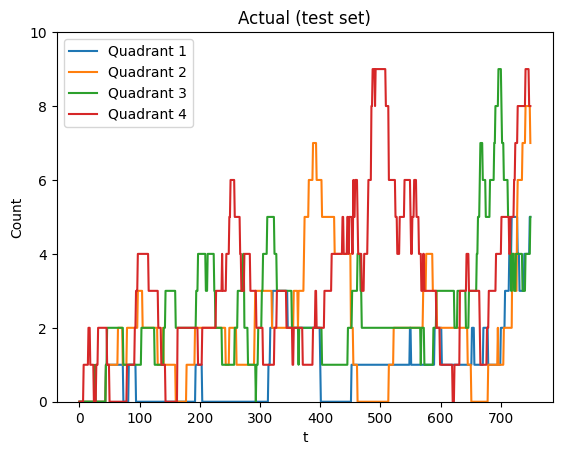

In [45]:
plt.figure(figsize=(10, 6))
# for quad in range(4):
#     plt.plot(range(750), train_counts[quad], label=f'Quadrant {quad}')

# plt.xlabel('Frame')
# plt.ylabel('Number of People')
# plt.title('Number of People per Quadrant Over Time (Train)')
# plt.legend()
# plt.show()

plt.figure()
for quad in range(4):
    plt.plot(range(750), test_counts[quad], label=f'Quadrant {quad+1}')

plt.xlabel("t")
plt.ylabel("Count")
plt.ylim(0,10)
plt.title("Actual (test set)")
plt.legend(loc="upper left")
plt.show()

In [46]:
train_pred_counts = [[quad_count(train_pred_gps)[frame][quad] for frame in range(750)] for quad in range(4)]
test_pred_counts = [[quad_count(test_pred_gps)[frame][quad] for frame in range(750)] for quad in range(4)]

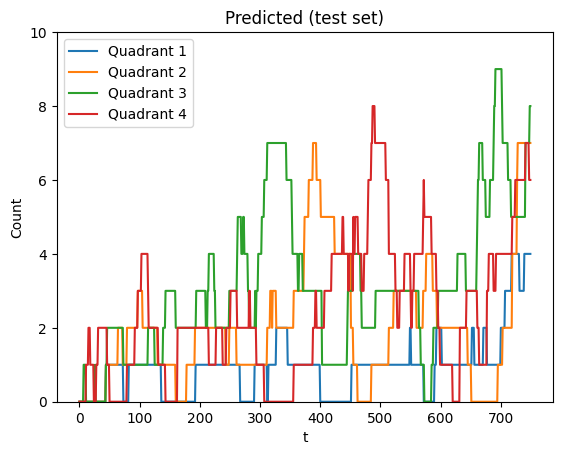

In [49]:
plt.figure()
for quad in range(4):
    plt.plot(range(750), test_pred_counts[quad], label=f'Quadrant {quad+1}')

plt.xlabel("t")
plt.ylabel("Count")
plt.ylim(0,10)
plt.title("Predicted (test set)")
plt.legend(loc="upper left")
plt.show()

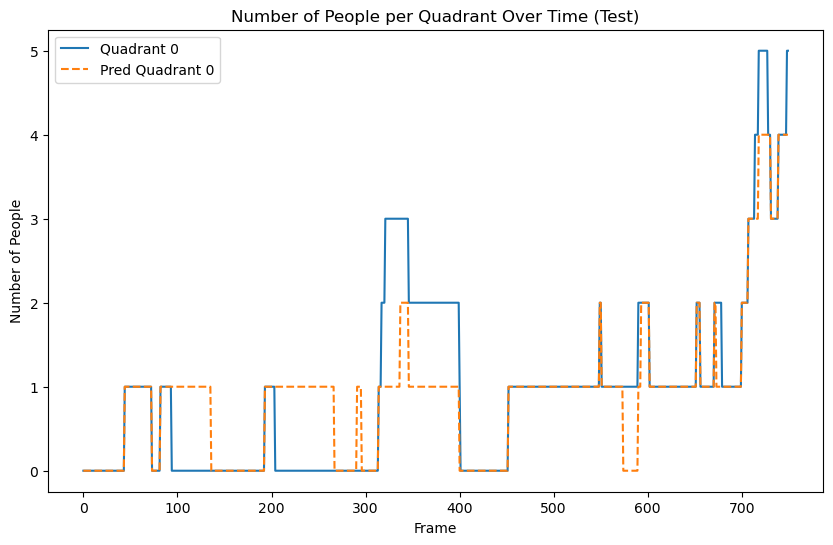

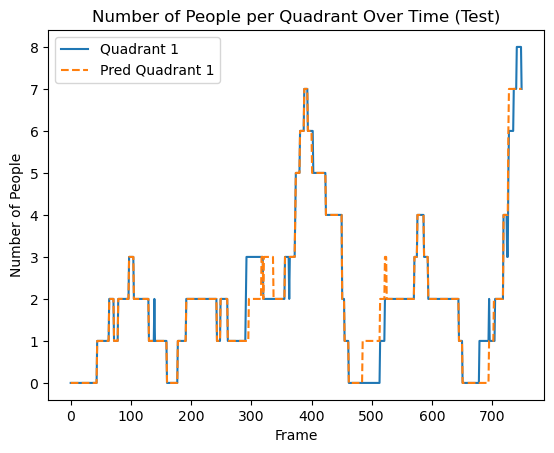

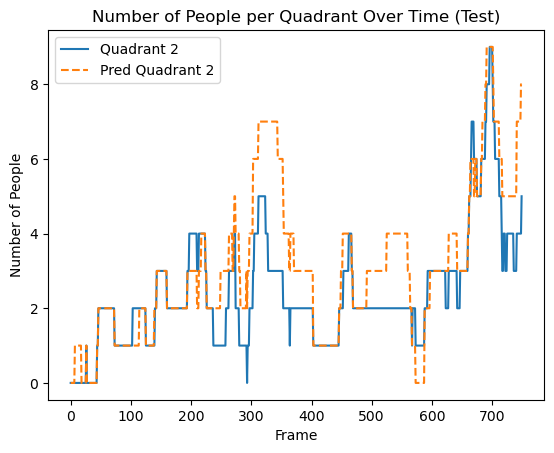

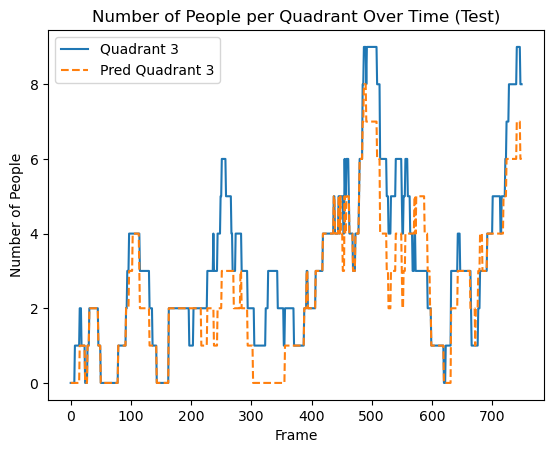

In [22]:
plt.figure(figsize=(10, 6))
for quad in range(4):
    plt.plot(range(750), test_counts[quad], label=f'Quadrant {quad}')

    plt.plot(range(750), test_pred_counts[quad], '--',label=f'Pred Quadrant {quad}')

    plt.xlabel('Frame')
    plt.ylabel('Number of People')
    plt.title('Number of People per Quadrant Over Time (Test)')
    plt.legend()
    plt.show()

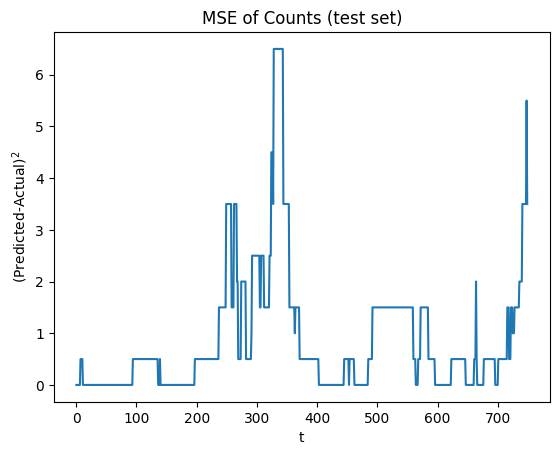

In [51]:
# train_mses = []
# true_quad = quad_count(filtered_train_true_gps)
# pred_quad = quad_count(train_pred_gps)
# for frame in true_quad:
#     true_count = np.array(true_quad[frame])
#     pred_count = np.array(pred_quad[frame])
#     mse = ((pred_count - true_count) ** 2).mean()
#     train_mses.append(mse)
# plt.plot(range(750), train_mses)
# plt.xlabel("t")
# plt.ylabel("MSE of Counts")
# plt.title("MSE of Counts (Train)")
# plt.show()

test_mses = []
true_quad = quad_count(filtered_test_true_gps)
pred_quad = quad_count(test_pred_gps)
for frame in true_quad:
    true_count = np.array(true_quad[frame])
    pred_count = np.array(pred_quad[frame])
    mse = ((pred_count - true_count) ** 2).mean()
    test_mses.append(mse)
plt.plot(range(750), test_mses)
plt.xlabel("t")
plt.ylabel(r"(Predicted-Actual)$^2$")
plt.title("MSE of Counts (test set)")
plt.show()

In [26]:
print(f"Mean MSE of Quadrant Counts Across Frames (Train): {np.nanmean(train_mses)}")
print(f"Std Dev of MSE of Quadrant Counts Across Frames (Train): {np.nanstd(train_mses)}")
# print(f"Max MSE of Quadrant Counts Across Frames (Train): {np.nanmax(train_mses)} @ Frame {np.nanargmax(train_mses)}")
# print(f"Min MSE of Quadrant Counts Across Frames (Train): {np.nanmin(train_mses)} @ Frame {np.nanargmin(train_mses)}")

Mean MSE of Quadrant Counts Across Frames (Train): 0.3486666666666667
Std Dev of MSE of Quadrant Counts Across Frames (Train): 0.5086893835032228


In [28]:
print(f"Mean MSE of Quadrant Counts Across Frames (Test): {np.nanmean(test_mses)}")
print(f"Std Dev of MSE of Quadrant Counts Across Frames (Test): {np.nanstd(test_mses)}")
# print(f"Max MSE of Quadrant Counts Across Frames (Test): {np.nanmax(test_mses)} @ Frame {np.nanargmax(test_mses)}")
# print(f"Min MSE of Quadrant Counts Across Frames (Test): {np.nanmin(test_mses)} @ Frame {np.nanargmin(test_mses)}")

Mean MSE of Quadrant Counts Across Frames (Test): 0.8866666666666667
Std Dev of MSE of Quadrant Counts Across Frames (Test): 1.2953077712351695
